In [9]:
# -*- coding: utf-8 -*-
import os, csv, random, math, time
from typing import Tuple, Optional
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
import cv2

def get_mean_std(csv_file: str):
    """
    优先从本地缓存读取 mean/std；没有就扫描 CSV 中的 rgb_path 计算一次并缓存。
    计算在 [0,1] 空间进行（TF.to_tensor 已经把 [0,255] 映射到 [0,1]）。
    """

    # 没缓存则计算
    sum_ = np.zeros(3, dtype=np.float64)
    sumsq_ = np.zeros(3, dtype=np.float64)
    n_pixels = 0

    with open(csv_file, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for r in reader:
            img = Image.open(r["rgb_path"]).convert("RGB")
            x = TF.to_tensor(img).numpy()  # [3,H,W] in [0,1]
            c, h, w = x.shape
            n = h * w
            sum_   += x.reshape(3, -1).sum(axis=1)
            sumsq_ += (x.reshape(3, -1) ** 2).sum(axis=1)
            n_pixels += n

    mean = (sum_ / n_pixels).astype(np.float32)
    var  = (sumsq_ / n_pixels - mean**2).astype(np.float32)
    std  = np.sqrt(np.clip(var, 1e-12, None)).astype(np.float32)

    return tuple(mean.tolist()), tuple(std.tolist())

In [11]:
print(get_mean_std("train_index.csv"))

((0.4871229827404022, 0.4702422022819519, 0.437697172164917), (0.22217848896980286, 0.2359304577112198, 0.26183003187179565))


In [2]:
# -*- coding: utf-8 -*-
import os, csv, random, math, time
from typing import Tuple, Optional
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
import cv2

# ====================== Config ======================
USE_PRETRAINED = False          # use ImageNet pretrained backbone
LR_MAIN = 3e-4                 # base LR
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 64
EPOCHS = 35
IMG_SIZE = (640, 480)
TRAIN_CSV = "train_index_with_mask.csv"  # 兼容无该列的CSV
CKPT_PATH = "resnet_depthaware_proxy_best.pth"
SEED = 7
MEAN_RGB =  (0.48711928725242615, 0.470241904258728, 0.4376976788043976)
STD_RGB  = (0.22217294573783875, 0.23592297732830048, 0.2618241310119629)
# ====================================================

# ---------------------- Depth-aware Resnet ----------------------
class DepthAwareConv2dLite(nn.Module):
    """
    Depth-guided local attention + linear projection (im2col + GEMM).
    """
    def __init__(self, in_channels, out_channels, stride=1, padding=1, bias=True, alpha_init=8.0):
        super().__init__()
        self.k, self.s, self.p = 3, stride, padding
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, 3, 3))
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        # softplus(alpha_raw) = alpha > 0 ; init near alpha_init
        self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))
        self.center_idx = 4

    @staticmethod
    def _norm01(D, eps=1e-6):
        dmin = D.amin(dim=(2,3), keepdim=True)
        dmax = D.amax(dim=(2,3), keepdim=True)
        return (D - dmin) / (dmax - dmin + eps)

    def forward(self, x, depth):
        B, C, H, W = x.shape
        D = self._norm01(depth)
        k, s, p = self.k, self.s, self.p

        # im2col
        x_win = F.unfold(x, kernel_size=k, padding=p, stride=s)       # [B, C*k*k, L]
        D_win = F.unfold(D, kernel_size=k, padding=p, stride=s)       # [B, 1*k*k, L]
        L = x_win.shape[-1]

        # depth-guided weights in window
        D_win = D_win.view(B, k*k, L)                                 # [B, 9, L]
        D_ctr = D_win[:, self.center_idx:self.center_idx+1, :]        # [B, 1, L]
        alpha = F.softplus(self.alpha_raw)
        score = -alpha * (D_ctr - D_win).abs()                        # [B, 9, L]
        a = torch.softmax(score, dim=1)                               # [B, 9, L]

        # apply weights to patches
        x_win = x_win.view(B, C, k*k, L)                              # [B, C, 9, L]
        x_mod = (x_win * a[:, None, :, :]).view(B, C*k*k, L)          # [B, C*9, L]

        # linear projection: Wmat @ x_mod
        Wmat = self.weight.view(self.weight.shape[0], -1)             # [out_ch, C*9]
        y_cols = torch.einsum('oc,bcl->bol', Wmat, x_mod)             # [B, out_ch, L]

        # fold
        H_out = (H + 2*p - k)//s + 1
        W_out = (W + 2*p - k)//s + 1
        return y_cols.view(B, -1, H_out, W_out)

class DAConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, s=1, alpha_init=8.0):
        super().__init__()
        self.conv = DepthAwareConv2dLite(in_ch, out_ch, stride=s, padding=1, bias=False, alpha_init=alpha_init)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x, depth):
        return self.act(self.bn(self.conv(x, depth)))

# ---------------------- Physics Proxy ----------------------
class DepthProxyPhysical(nn.Module):
    def __init__(self,
                 fx: Optional[float] = None,
                 fy: Optional[float] = None,
                 unit_per_m: float = 10000.0,     # e.g., raw 10000 == 1m
                 Z_plane_m: float = 2.0,          # table plane (meters)
                 A_px_cm2: float = 0.01,          # fallback pixel area (cm^2) when fx/fy is None
                 q_percent: float = 0.8,          # 80th percentile
                 bins: int = 128):                # histogram bins
        super().__init__()
        self.fx = fx
        self.fy = fy
        self.unit_per_m = unit_per_m
        self.Z_plane_m = Z_plane_m
        self.A_px_cm2 = A_px_cm2
        self.q_percent = q_percent
        self.bins = bins

        # precompute constants
        if (fx is not None) and (fy is not None):
            self.register_buffer("inv_fx_fy", torch.tensor(1.0 / (fx * fy), dtype=torch.float32))
        else:
            self.inv_fx_fy = None

        # small positive to avoid degenerate bins
        self.zmin_eps = 1e-6

    @torch.no_grad()
    def forward(self, depth_raw_uint16: torch.Tensor,
                plate_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        depth_raw_uint16: [B,1,H,W] uint16 raw depth (e.g., 1m=10000)
        plate_mask:      [B,1,H,W] bool/int {0,1}, optional
        Returns: [B,2] -> [area_cm2, volume_cm3_proxy]
        """
        # ----- depth to meters -----
        # Z_cam in [0, Z_plane_m], [B,1,H,W], float32
        Z_cam = (depth_raw_uint16.float() / self.unit_per_m).clamp_(0.0, self.Z_plane_m)
        valid = (Z_cam > 0)

        # ----- region mask -----
        if plate_mask is not None:
            if plate_mask.dtype != torch.bool:
                plate_mask = (plate_mask > 0)
            region = valid & plate_mask
        else:
            region = valid

        B = Z_cam.shape[0]
        N = Z_cam.numel() // B  # H*W

        # ----- histogram-based q80 (all on GPU, no NaN) -----
        # flatten per batch
        Zf = Z_cam.view(B, -1)                       # [B, N]
        Wf = region.view(B, -1).float()              # [B, N] in {0,1}

        zmin = self.zmin_eps
        zmax = float(self.Z_plane_m)

        # normalize Z to [0,1], clamp into [zmin, zmax] first
        Zn = (Zf.clamp(zmin, zmax) - zmin) / (zmax - zmin)   # [B, N] in [0,1]

        # compute bin indices in [0, bins-1]
        bins = int(self.bins)
        idx = (Zn * bins).floor_().clamp_(0, bins - 1).long()   # [B, N]

        # weighted histogram per batch via scatter_add_
        counts = torch.zeros((B, bins), device=Zf.device, dtype=Zf.dtype)  # [B, bins]
        counts.scatter_add_(dim=1, index=idx, src=Wf)  # add mask weights (0/1)

        # cumulative distribution -> CDF
        tot = counts.sum(dim=1, keepdim=True)                    # [B,1]
        cdf = counts.cumsum(dim=1) / (tot + 1e-6)                # [B, bins]

        # handle empty region: tot == 0 -> use zmax
        empty = (tot.squeeze(1) <= 0)

        # find first bin where CDF >= q_percent
        th = torch.full((B, 1), float(self.q_percent), device=Zf.device, dtype=Zf.dtype)  # [B,1]
        bin_idx = torch.searchsorted(cdf, th, right=False).squeeze(1)   # [B]
        bin_idx = bin_idx.clamp_(max=bins - 1)

        # convert bin index to depth value (bin center)
        bin_center = (bin_idx.to(Zf.dtype) + 0.5) / bins                 # [B]
        q80 = zmin + bin_center * (zmax - zmin)                          # [B]
        # empty fallback -> q80 = zmax
        if empty.any():
            q80 = torch.where(empty, torch.full_like(q80, zmax), q80)

        q80 = q80.view(B, 1, 1, 1)                                       # [B,1,1,1]

        # ----- near-field mask -----
        mask_food = (region & (Z_cam <= q80)).float()                    # [B,1,H,W] in {0,1}

        # ----- integrate area / volume -----
        if self.inv_fx_fy is not None:
            # A_px_m2 = Z^2 / (fx*fy)
            Z_sq = Z_cam * Z_cam
            A_px_m2 = Z_sq * self.inv_fx_fy                               # [B,1,H,W]
            area_cm2 = (A_px_m2 * mask_food).sum(dim=(1, 2, 3)) * 1e4     # m^2 -> cm^2

            h_m = (self.Z_plane_m - Z_cam).clamp_(min=0.0)                # [B,1,H,W]
            tint_cm3 = (h_m * A_px_m2 * mask_food).sum(dim=(1, 2, 3)) * 1e6  # m^3 -> cm^3
        else:
            # Fallback: per-pixel area constant in cm^2
            area_cm2 = mask_food.sum(dim=(1, 2, 3)) * self.A_px_cm2

            h_m = (self.Z_plane_m - Z_cam).clamp_(min=0.0)
            # proxy volume: sum(h) * pixel_area(cm^2); h in m -> multiply by 100 to cm
            tint_cm3 = (h_m * mask_food).sum(dim=(1, 2, 3)) * (self.A_px_cm2 * 100.0)

        return torch.stack([area_cm2, tint_cm3], dim=1)                  # [B,2]

# ---------------------- Model ----------------------
class DepthAwareResNet18ProxyMLP(nn.Module):
    def __init__(self, fx: Optional[float]=None, fy: Optional[float]=None):
        super().__init__()
        # Depth-aware stem replaces conv1+bn1+relu
        self.stem_da = DAConvBNReLU(3, 64, s=2, alpha_init=4.0)
        self.maxpool = nn.MaxPool2d(3,2,1)

        base = resnet18(weights=None)

        # take backbone layers
        self.layer1, self.layer2 = base.layer1, base.layer2
        self.layer3, self.layer4 = base.layer3, base.layer4
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = 512

        # physics proxy
        self.proxy = DepthProxyPhysical(fx=fx, fy=fy)
        self.proxy_bn = nn.BatchNorm1d(2)  # normalize (area, volume) before concat

        # head
        self.head = nn.Sequential(
            nn.Linear(self.feat_dim + 2, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.1),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

        # mark which parts are pretrained for optional freezing
        self.backbone_modules = nn.ModuleList([self.layer1, self.layer2, self.layer3, self.layer4])

    def forward(self, rgb, depth_raw_uint16, plate_mask=None):
        # --- backbone ---
        x = self.stem_da(rgb, depth_raw_uint16 / 10000.0)
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        feat = self.avgpool(x).flatten(1)  # [B,512]

        # --- proxy (no grad, 可在 CPU) ---
        with torch.no_grad():
            proxy = self.proxy(depth_raw_uint16, plate_mask=plate_mask)  # 保持与 rgb 同设备
        proxy = proxy.to(feat.dtype)

        z = torch.cat([feat, proxy], dim=1)
        return self.head(z)

# ---------------------- Dataset (RGB + Depth + PlateMask) ----------------------

class RGBDDataset(Dataset):
    """
    CSV columns must include: dish_id,label,rgb_path,depth_color_path,depth_raw_path
    Optional column: plate_mask_path
    Returns: (rgb, depth, plate_mask), y, dish_id
      - rgb  : float32 [3,H,W], normalized by mean/std
      - depth: float32 [1,H,W], raw units (e.g., 1m=10000), resized by NEAREST
      - plate_mask: bool [1,H,W], all zeros if not provided
    """
    def __init__(self, csv_file, out_size=IMG_SIZE, augment=False,
                 mean_rgb=(0.0,0.0,0.0), std_rgb=(1.0,1.0,1.0)):
        super().__init__()
        self.W, self.H = out_size
        self.augment = augment
        self.rows = []
        with open(csv_file, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            header = reader.fieldnames or []
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r["dish_id"],
                    "label": float(r["label"]),
                    "rgb": r["rgb_path"],
                    "drgb": r.get("depth_color_path",""),
                    "draw": r["depth_raw_path"],
                    "plate_mask_path": r.get("plate_mask_path","")
                })
        
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)  # uint16 raw
        if d is None:
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)
        d = torch.from_numpy(d).unsqueeze(0)    # [1,H,W]
        return d

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)

        rgb_path   = row["rgb"]
        depth_path = row["draw"]

        # default all-zero mask
        plate_mask = torch.zeros(1, self.H, self.W, dtype=torch.bool)
        pm_path = row.get("plate_mask_path","")
        if pm_path:
            m = cv2.imread(pm_path, cv2.IMREAD_GRAYSCALE)
            if m is not None:
                m = (m > 127).astype(np.uint8)
                plate_mask = torch.from_numpy(m)[None].float()
                plate_mask = TF.resize(plate_mask, (self.H, self.W),
                                       interpolation=InterpolationMode.NEAREST).bool()

        rgb   = self._load_rgb(rgb_path)
        depth = self._load_depth_raw(depth_path)

        # Resize (keep alignment). If you enable augment, ensure the same geom ops apply to depth/mask too.
        if self.augment:
            # Minimal: only RGB photometric aug here (safe). For full geom aug, you must sync ops for depth & mask.
            scale = random.uniform(0.7, 1.0)
            h,w = rgb.shape[-2:]
            th,tw = int(h*scale), int(w*scale)
            i = random.randint(0, h-th) if th < h else 0
            j = random.randint(0, w-tw) if tw < w else 0
            rgb = TF.resized_crop(rgb, i, j, th, tw, (self.H,self.W))
            ang = random.uniform(-8,8)
            rgb = TF.rotate(rgb, ang)
            if random.random() < 0.5: rgb = TF.hflip(rgb)
            rgb = TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
            rgb = TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
            rgb = TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
            rgb = TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
            plate_mask = TF.resize(plate_mask.float(), (self.H,self.W),
                                   interpolation=InterpolationMode.NEAREST).bool()
        else:
            rgb   = TF.resize(rgb,   (self.H,self.W))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
            plate_mask = TF.resize(plate_mask.float(), (self.H,self.W),
                                   interpolation=InterpolationMode.NEAREST).bool()

        # normalize RGB
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return (rgb, depth, plate_mask), y, row["dish_id"]

    def __len__(self): 
        return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    
    for (rgb, depth, plate_mask), y, _ in loader:
        rgb        = rgb.to(device, non_blocking=True)
        depth      = depth.to(device, non_blocking=True)
        plate_mask = plate_mask.to(device, non_blocking=True)
        y          = y.to(device, non_blocking=True)
        p = model(rgb, depth, plate_mask=plate_mask)
        mse_sum += F.mse_loss(p, y, reduction="sum").item()
        mae_sum += torch.abs(p - y).sum().item()
        n += y.size(0)
    return {"MSE":mse_sum/n, "MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    print(len(loader))
    for (rgb, depth, plate_mask), y, _ in loader:
        rgb        = rgb.to(device)
        depth      = depth.to(device)
        plate_mask = plate_mask.to(device)
        y          = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        pred = model(rgb, depth, plate_mask=plate_mask)
        print(3)
        loss = F.mse_loss(pred, y)
        loss.backward()
        print(4)

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total += loss.item() * y.size(0)
        n     += y.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_resnet_mlp():
    set_seed(SEED)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # dataset & split
    mean_rgb, std_rgb = MEAN_RGB, STD_RGB
    tmp_ds = RGBDDataset(TRAIN_CSV, out_size=IMG_SIZE, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDDataset(TRAIN_CSV, out_size=IMG_SIZE, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(TRAIN_CSV, out_size=IMG_SIZE, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # model
    model = DepthAwareResNet18ProxyMLP().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_MAIN, weight_decay=WEIGHT_DECAY)

    train_losses, val_losses = [], []
    best_val = float("inf")

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr)
        val_losses.append(val["MSE"])

        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")

        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgbd_da",
                "in_ch": 3,
            }, CKPT_PATH)

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("DepthAware ResNet18 + Proxy (RGB-D)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



In [3]:
train_resnet_mlp()

C:\Users\Admin\AppData\Local\Temp\ipykernel_49536\1949450850.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))


38
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
Epoch 001 | Train 77595.9906 | Val MSE 38025.1739 | Val MAE 151.77
38
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
Epoch 002 | Train 57009.4740 | Val MSE 37135.3203 | Val MAE 153.93
38
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
Epoch 003 | Train 52880.4625 | Val MSE 38553.2210 | Val MAE 146.90
38
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
Epoch 004 | Train 50832.8479 | Val MSE 34505.5492 | Val MAE 147.32
38
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3
4
3

KeyboardInterrupt: 

In [8]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [24]:
# -*- coding: utf-8 -*-
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def main():
    parser = argparse.ArgumentParser(description="Plot label distribution as a histogram.")
    parser.add_argument("--csv", type=str, default="train_index_0.csv.csv")
    parser.add_argument("--col", type=str, default="label")
    parser.add_argument("--bins", type=int, default=40)
    parser.add_argument("--output", type=str, default="label_hist.png")
    args, _ = parser.parse_known_args()

    # Read CSV
    df = pd.read_csv(args.csv)
    if args.col not in df.columns:
        raise ValueError(f"Column '{args.col}' not found. Available: {list(df.columns)}")

    # Convert to float and keep only finite values
    y = pd.to_numeric(df[args.col], errors="coerce").dropna().astype(float)
    y = y[np.isfinite(y)]

    # --------- Stats ----------
    over_1500 = (y > 1500).sum()
    ratio = over_1500 / len(y) * 100 if len(y) > 0 else 0.0
    print(f"\nCount: {len(y)}")
    print(f">1500 count: {over_1500}  ({ratio:.2f}%)")
    if len(y) > 0:
        print(f"Min/Max: {y.min()} / {y.max()}")
        print(f"Mean/Std: {y.mean():.4f} / {y.std():.4f}")
    # --------------------------
    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=args.bins, edgecolor="black")  # edgecolor for clarity
    plt.xlabel(args.col)
    plt.ylabel("Count")
    plt.title(f"Calorie Value distribution (bins={args.bins})")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(args.output, dpi=150)
    print(f"Saved to {args.output}")

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: 'train_index_0.csv.csv'


[Linear domain stats]
Count: 3301
>1500 count: 1  (0.03%)
Min/Max: 0.0 / 3943.325195
Mean/Std: 237.3746 / 221.2951

Saved to label_hist.png


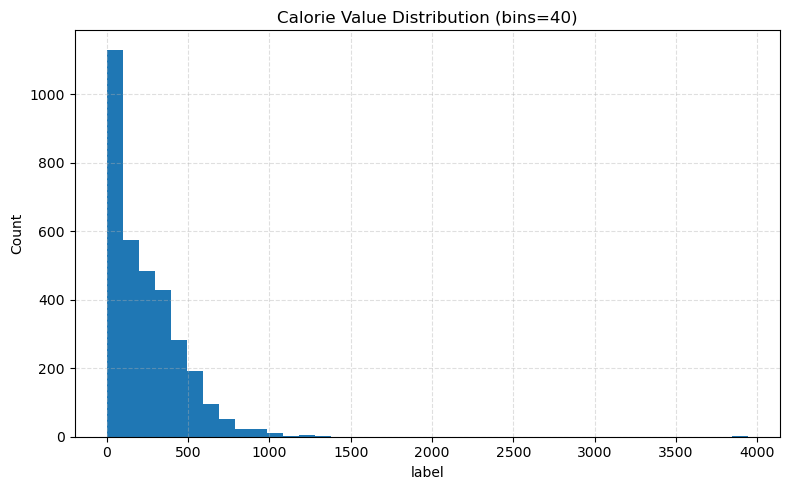

In [27]:
import argparse, pandas as pd, matplotlib.pyplot as plt
import numpy as np

def main():
    parser = argparse.ArgumentParser(description="Plot label distribution as a histogram (optionally log-transformed).")
    parser.add_argument("--csv", type=str, default="train_index_0.csv")
    parser.add_argument("--col", type=str, default="label")
    parser.add_argument("--bins", type=int, default=40)
    parser.add_argument("--output", type=str, default="label_hist.png")

    # ---- log transform controls ----
    parser.add_argument("--log", action="store_true",
                        help="Apply log transform to the column before plotting and stats.")
    parser.add_argument("--log_base", type=str, choices=["e", "10", "2"], default="e",
                        help="Log base to use if --log is enabled.")
    parser.add_argument("--log_eps", type=float, default=0.0,
                        help="Small epsilon added BEFORE log to handle zeros (use only if you must).")
    args, _ = parser.parse_known_args()

    df = pd.read_csv(args.csv)
    if args.col not in df.columns:
        raise ValueError(f"Column '{args.col}' not found. Available: {list(df.columns)}")

    y_raw = df[args.col].dropna().astype(float)

    # ---------- linear-domain stats ----------
    over_1500 = (y_raw > 1500).sum()
    ratio = over_1500 / len(y_raw) * 100
    print("\n[Linear domain stats]")
    print(f"Count: {len(y_raw)}")
    print(f">1500 count: {over_1500}  ({ratio:.2f}%)")
    print(f"Min/Max: {y_raw.min()} / {y_raw.max()}")
    print(f"Mean/Std: {y_raw.mean():.4f} / {y_raw.std(ddof=0):.4f}")

    # ---------- prepare data for plotting ----------
    data_for_plot = y_raw.copy()
    plot_xlabel = args.col

    if args.log:
        # keep only positive values; warn on dropped
        if args.log_eps <= 0:
            y_pos = y_raw[y_raw > 0]
            dropped = len(y_raw) - len(y_pos)
            if dropped > 0:
                print(f"\n[Warn] Dropped {dropped} non-positive samples before log (min={y_raw.min()}).")
        else:
            # add epsilon BEFORE log to shift zeros; still need strictly > -eps
            y_pos = y_raw[y_raw > -args.log_eps]
            dropped = len(y_raw) - len(y_pos)
            if dropped > 0:
                print(f"\n[Warn] Dropped {dropped} samples <= -eps ({-args.log_eps}).")

        # pick log function by base
        if args.log_base == "e":
            log_fn = np.log
            base_str = "ln"
        elif args.log_base == "10":
            log_fn = np.log10
            base_str = "log10"
        else:
            log_fn = np.log2
            base_str = "log2"

        # apply log (with optional epsilon)
        data_for_plot = log_fn(y_pos + (args.log_eps if args.log_eps > 0 else 0.0))

        # ---------- log-domain stats ----------
        mu = data_for_plot.mean()
        sigma = data_for_plot.std(ddof=0)

        print("\n[Log domain stats]")
        print(f"Base: {base_str}")
        print(f"Count (after filtering): {len(data_for_plot)}")
        print(f"Min/Max (log): {data_for_plot.min():.6f} / {data_for_plot.max():.6f}")
        print(f"Mean/Std (log): {mu:.6f} / {sigma:.6f}")

        # (Optional) back-transform: geometric mean & log-normal scale hints
        # Convert back depending on base to show geometric mean in linear domain
        if args.log_base == "e":
            geom_mean = float(np.exp(mu))
        elif args.log_base == "10":
            geom_mean = float(10 ** mu)
        else:
            geom_mean = float(2 ** mu)
        print(f"Geometric mean (linear): {geom_mean:.6f}")

        plot_xlabel = f"{base_str}({args.col})"

    # ---------- plot ----------
    plt.figure(figsize=(8, 5))
    plt.hist(data_for_plot, bins=args.bins)
    plt.xlabel(plot_xlabel)
    plt.ylabel("Count")
    title_suffix = f"{'log-' if args.log else ''}bins={args.bins}"
    plt.title(f"Calorie Value Distribution ({title_suffix})")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(args.output, dpi=150)
    print(f"\nSaved to {args.output}")

if __name__ == "__main__":
    main()


In [14]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision.models import resnet18

# ---------------------- (Original) Depth-aware Resnet blocks (kept but unused) ----------------------
class DepthAwareConv2dLite(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1, bias=False, alpha_init=8.0):
        super().__init__()
        self.k, self.s, self.p = 3, stride, padding
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, 3, 3))
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        # NOTE: kept for compatibility, not used in the RGBD stem version
        self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))
        self.center_idx = 4

    @staticmethod
    def _norm01_masked(D, eps=1e-6):
        valid = (D > 0)
        if not valid.any():
            return torch.zeros_like(D)
        D_valid = torch.where(valid, D, torch.tensor(float('inf'), device=D.device, dtype=D.dtype))
        dmin = D_valid.amin(dim=(2,3), keepdim=True)
        D_valid = torch.where(valid, D, torch.tensor(float('-inf'), device=D.device, dtype=D.dtype))
        dmax = D_valid.amax(dim=(2,3), keepdim=True)
        same = (dmax - dmin) < eps
        dmin = torch.where(same, dmin - 0.5, dmin)
        dmax = torch.where(same, dmax + 0.5, dmax)
        Dn = (D - dmin) / (dmax - dmin + eps)
        Dn = torch.where(valid, Dn, torch.zeros_like(D))
        return Dn

    def _fill_holes_mean(self, D, ksize=5, eps=1e-6):
        valid = (D > 0).float()
        kernel = torch.ones(1, 1, ksize, ksize, device=D.device, dtype=D.dtype)
        pad = ksize // 2
        num = F.conv2d(valid, kernel, padding=pad)
        sm  = F.conv2d(D * valid, kernel, padding=pad)
        avg = sm / (num + eps)
        D_filled = torch.where(valid > 0, D, avg)
        return D_filled

    def forward(self, x, depth):
        # kept for compatibility; not used in the 4-channel stem version
        B, C, H, W = x.shape
        D = depth
        D = self._fill_holes_mean(D, ksize=5)
        D = self._norm01_masked(D)
        k, s, p = self.k, self.s, self.p
        x_win = F.unfold(x, kernel_size=k, padding=p, stride=s)
        D_win = F.unfold(D, kernel_size=k, padding=p, stride=s)
        L = x_win.shape[-1]
        D_win = D_win.view(B, k*k, L)
        D_ctr = D_win[:, self.center_idx:self.center_idx+1, :]
        alpha = F.softplus(self.alpha_raw)
        score = -alpha * (D_ctr - D_win).abs()
        a = torch.softmax(score, dim=1)
        x_win = x_win.view(B, C, k*k, L)
        x_mod = (x_win * a[:, None, :, :]).view(B, C*k*k, L)
        Wmat = self.weight.view(self.weight.shape[0], -1)
        y_cols = torch.einsum('oc,bcl->bol', Wmat, x_mod)
        H_out = (H + 2*p - k)//s + 1
        W_out = (W + 2*p - k)//s + 1
        return y_cols.view(B, -1, H_out, W_out)

class DAConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, s=1, alpha_init=8.0):
        super().__init__()
        self.conv = DepthAwareConv2dLite(in_ch, out_ch, stride=s, padding=1, bias=False, alpha_init=alpha_init)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x, depth):
        return self.act(self.bn(self.conv(x, depth)))

# ---------------------- New: Simple 4-channel (RGB + depth) stem ----------------------
class RGBDConvBNReLU(nn.Module):
    """Vanilla 3x3 Conv that takes 4-channel input: [RGB(3) + depth(1)]"""
    def __init__(self, out_ch=64, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(4, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
    def forward(self, x4):
        return self.act(self.bn(self.conv(x4)))

# ---------------------- Depth-Aware ResNet + Proxy + MLP ----------------------
class DepthProxyPhysical(nn.Module):
    def __init__(self, A_px_cm2=5.957e-3, Z_plane_cm=35.9, unit_per_m=10000):
        super().__init__()
        self.A_px_cm2 = A_px_cm2
        self.Z_plane_m = Z_plane_cm / 100.0
        self.unit_per_m = unit_per_m

    @torch.no_grad()
    def forward(self, depth_raw_uint16):
        Z_cam = depth_raw_uint16.float() / self.unit_per_m
        Z_cam = torch.clamp(Z_cam, 0.0, self.Z_plane_m)
        valid = (Z_cam > 0)

        B = Z_cam.shape[0]
        q80 = []
        for b in range(B):
            v = Z_cam[b,0][valid[b,0]]
            q80.append(torch.quantile(v, 0.8) if v.numel()>0 else torch.tensor(self.Z_plane_m, device=Z_cam.device))
        q80 = torch.stack(q80).view(B,1,1,1)

        mask_food = valid & (Z_cam <= q80)
        area_cm2 = mask_food.float().sum(dim=(1,2,3)) * self.A_px_cm2
        h_m = torch.clamp(self.Z_plane_m - Z_cam, min=0.0)
        tint_cm3 = (h_m * mask_food).sum(dim=(1,2,3)) * (self.A_px_cm2 * 100.0)
        return torch.stack([area_cm2, tint_cm3], dim=1)

# ---------------------- Dataset (RGB + Depth) ----------------------
class RGBDDataset(Dataset):
    """
    CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path
    Returns: (rgb, depth), y, dish_id
      - rgb: normalized by your dataset mean/std (float32, [3,H,W])
      - depth: raw uint16 (float32), 1m=10000 (float32, [1,H,W])
    """
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0,0,0), std_rgb=(1,1,1)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)  # uint16 raw, 1m = 10000
        if d is None:
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)                # [H,W]
        d = torch.from_numpy(d).unsqueeze(0)    # [1,H,W]
        return d

    def _augment_rgb_only(self, rgb):
        scale = random.uniform(0.7, 1.0)
        h,w = rgb.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        rgb = TF.resized_crop(rgb, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        rgb = TF.rotate(rgb, ang)
        if random.random() < 0.5: rgb = TF.hflip(rgb)
        rgb = TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
        return rgb

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)

        rgb_path   = row["rgb"]
        depth_path = row["draw"]

        rgb   = self._load_rgb(rgb_path)
        depth = self._load_depth_raw(depth_path)

        if self.augment:
            rgb = self._augment_rgb_only(rgb)
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
        else:
            rgb   = TF.resize(rgb,   (self.H,self.W))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)

        return (rgb, depth), y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for (rgb, depth), y, _ in loader: 
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        p = model(rgb, depth) 
        mse_sum += F.mse_loss(p, y, reduction="sum").item()
        mae_sum += torch.abs(p - y).sum().item()
        n += y.size(0)
    return {"MSE":mse_sum/n, "MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, criterion, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for (rgb, depth), y, _ in loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(rgb, depth)
        loss = criterion(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total += loss.item() * y.size(0)
        n     += y.size(0)
    return total / max(1, n)

# ---------------------- Model with 4-channel stem ----------------------
class DepthAwareResNet18ProxyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # NEW: 4-channel stem (RGB + depth_norm)
        self.stem_rgbd = RGBDConvBNReLU(out_ch=64, stride=2)
        self.maxpool = nn.MaxPool2d(3,2,1)

        # backbone
        base = resnet18(weights=None)  # no pretrain
        self.layer1, self.layer2 = base.layer1, base.layer2
        self.layer3, self.layer4 = base.layer3, base.layer4
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = 512

        # proxy (unchanged)
        self.proxy = DepthProxyPhysical()

        # head: concat 512+2 -> 256 -> 64 -> 1
        self.head = nn.Sequential(
            nn.Linear(self.feat_dim + 2, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, rgb, depth_raw_uint16):
        # concat normalized depth as 4th channel
        depth_norm = depth_raw_uint16 / 10000.0  # keep the same unit convention
        x_in = torch.cat([rgb, depth_norm], dim=1)  # [B,4,H,W]
        x = self.stem_rgbd(x_in)
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        feat = self.avgpool(x).flatten(1)  # [B,512]

        proxy = self.proxy(depth_raw_uint16)  # [B,2]
        z = torch.cat([feat, proxy], dim=1)
        return self.head(z)  # [B,1]

# ---------------------- Main ----------------------
def train_resnet_mlp_0_depth():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index_0.csv"

    # dataset RGB stats
    mean_rgb=(0.48711928725242615, 0.470241904258728, 0.4376976788043976)
    std_rgb= (0.22217294573783875, 0.23592297732830048, 0.2618241310119629)
    print("RGB mean/std from dataset:", mean_rgb, std_rgb)

    # split indices
    tmp_ds_for_len = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds_for_len)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    # datasets/loaders
    train_full = RGBDDataset(train_csv, augment=False,  mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=False)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    # model + optimizer
    model = DepthAwareResNet18ProxyMLP().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    # Huber (SmoothL1) Loss
    HUBER_BETA = 50.0
    criterion = torch.nn.SmoothL1Loss(beta=HUBER_BETA, reduction='mean')

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 20

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device, criterion)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | TrainHuber {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MAE"] < best_val:
            best_val = val["MAE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgbd_4ch",  # mark new mode
                "in_ch": 4,
            }, "tinycnn_rgbd4_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Huber")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN (RGB + Depth-as-4th-Channel) - Huber")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


RGB mean/std from dataset: (0.48711928725242615, 0.470241904258728, 0.4376976788043976) (0.22217294573783875, 0.23592297732830048, 0.2618241310119629)
Epoch 001 | TrainHuber 200.3923 | Val MSE 64143.0273 | Val MAE 176.19
Epoch 002 | TrainHuber 126.2780 | Val MSE 29585.1455 | Val MAE 113.06
Epoch 003 | TrainHuber 88.5369 | Val MSE 25313.0953 | Val MAE 99.50
Epoch 004 | TrainHuber 73.9999 | Val MSE 39571.9324 | Val MAE 129.62
Epoch 005 | TrainHuber 67.7279 | Val MSE 21106.1471 | Val MAE 85.66
Epoch 006 | TrainHuber 63.5345 | Val MSE 19443.4160 | Val MAE 84.21
Epoch 007 | TrainHuber 57.9353 | Val MSE 25318.9238 | Val MAE 105.27
Epoch 008 | TrainHuber 55.6224 | Val MSE 17124.1456 | Val MAE 79.86
Epoch 009 | TrainHuber 54.9768 | Val MSE 15332.2011 | Val MAE 73.05
Epoch 010 | TrainHuber 52.8237 | Val MSE 9836.8374 | Val MAE 62.98
Epoch 011 | TrainHuber 50.5199 | Val MSE 11198.8654 | Val MAE 68.53
Epoch 012 | TrainHuber 50.0598 | Val MSE 17521.4509 | Val MAE 87.88
Epoch 013 | TrainHuber 47.01

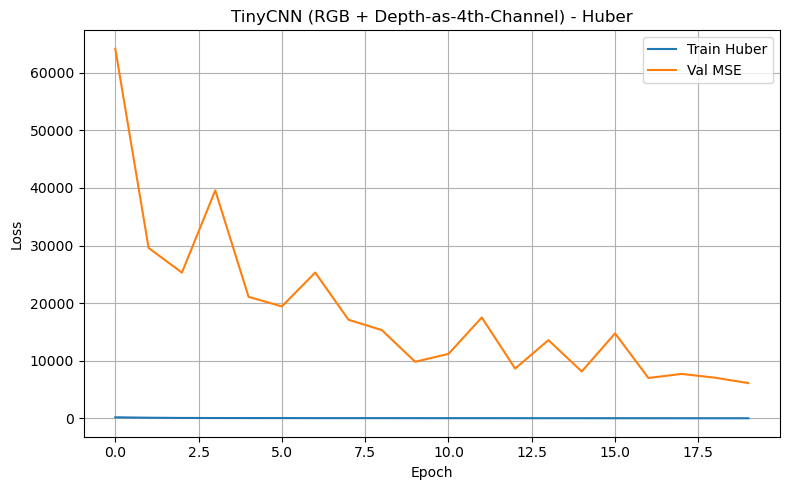

In [15]:
train_resnet_mlp_0_depth()

In [18]:
# ---------------------- Test Folder Inference (append-only) ----------------------
class TestFolderDataset(Dataset):
    """
    只读测试集：根目录下有 color/ depth_raw/，其下按 dish_id 子目录。
    每个 dish_id 取第一个图。无 label。
    返回: (rgb_normed[3,H,W], depth_raw[1,H,W]), dish_id
    """
    def __init__(self, root_dir, out_size=(384,384), mean_rgb=(0,0,0), std_rgb=(1,1,1)):
        super().__init__()
        self.root = root_dir
        self.H, self.W = out_size
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

        self.rgb_root  = os.path.join(root_dir, "color")
        self.draw_root = os.path.join(root_dir, "depth_raw")

        ids = set()
        if os.path.isdir(self.rgb_root):
            ids |= set([d for d in os.listdir(self.rgb_root) if os.path.isdir(os.path.join(self.rgb_root, d))])
        if os.path.isdir(self.draw_root):
            ids |= set([d for d in os.listdir(self.draw_root) if os.path.isdir(os.path.join(self.draw_root, d))])
        self.dish_ids = sorted(list(ids))

    def _first_png(self, dirpath):
        if not os.path.isdir(dirpath): return ""
        for f in sorted(os.listdir(dirpath)):
            if f.lower().endswith(".png"):
                return os.path.join(dirpath, f)
        return ""

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)
        if d is None:
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)              # 原始单位: 1m=10000
        return torch.from_numpy(d)[None, ...] # [1,H,W]

    def __len__(self): return len(self.dish_ids)

    def __getitem__(self, idx):
        did = self.dish_ids[idx]
        rgb_p  = self._first_png(os.path.join(self.rgb_root,  did))
        draw_p = self._first_png(os.path.join(self.draw_root, did))
        if rgb_p == "" or draw_p == "":
            rgb   = torch.zeros(3, self.H, self.W, dtype=torch.float32)
            depth = torch.zeros(1, self.H, self.W, dtype=torch.float32)
        else:
            rgb   = self._load_rgb(rgb_p)
            depth = self._load_depth_raw(draw_p)

        # resize（保持对齐）
        rgb   = TF.resize(rgb,   (self.H,self.W))
        depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        # 与训练一致的 RGB 归一化（depth 不在这归一化！让模型里 /10000.0）
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return (rgb, depth), did


@torch.no_grad()
def infer_test_folder(model_cls, ckpt_path, test_dir, mean_rgb, std_rgb,
                      out_csv="submission_0.csv", img_size=384, batch_size=64, device=None,
                      log_nz_every=1):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # 1) 构建同结构模型并加载 best 权重
    model = model_cls().to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    # 2) DataLoader
    test_ds = TestFolderDataset(test_dir, out_size=(img_size, img_size),
                                mean_rgb=mean_rgb, std_rgb=std_rgb)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=torch.cuda.is_available())

    # 3) 推理（单层循环；直接用当前 batch 的 depth 统计）
    results = []
    for i, ((rgb, depth), did) in enumerate(test_loader):
        if (log_nz_every is not None) and (i % max(1, log_nz_every) == 0):
            nz = (depth > 0).float().mean().item()
            print(f"[batch {i}] nonzero(depth) ratio = {nz:.3f}")

        rgb   = rgb.to(device, non_blocking=True)     # [B,3,H,W]
        depth = depth.to(device, non_blocking=True)   # [B,1,H,W] (raw)
        pred  = model(rgb, depth).squeeze(1).detach().cpu().numpy().tolist()

        for d, p in zip(list(did), pred):
            results.append((d, float(p)))

    # 4) 写出 CSV
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["ID", "Value"])
        w.writerows(results)
    print(f"[OK] wrote {len(results)} rows -> {out_csv}")


In [19]:
TEST_DIR = r".\Nutrition5K\Nutrition5K\test"   # <<< 换成你的测试集根目录
infer_test_folder(
    model_cls=DepthAwareResNet18ProxyMLP,
    ckpt_path="tinycnn_rgbd4_best.pth",
    test_dir=TEST_DIR,
    mean_rgb=(0.48711928725242615, 0.470241904258728, 0.4376976788043976),
    std_rgb= (0.22217294573783875, 0.23592297732830048, 0.2618241310119629),
    out_csv="submission_depth.csv",
    img_size=480,
    batch_size=64,
    device="cuda"
)

[batch 0] nonzero(depth) ratio = 0.840
[batch 1] nonzero(depth) ratio = 0.823
[batch 2] nonzero(depth) ratio = 0.830
[OK] wrote 189 rows -> submission_depth.csv
